In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# Step 1: Define Dataset Path & Parameters
dataset_path = r"C:\Users\Lenovo\Downloads\Material_defect_classification\dataset\NEU-DET"
train_dir = os.path.join(dataset_path, "train", "images")  # Updated path
val_dir = os.path.join(dataset_path, "validation", "images")  # Updated path
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))
img_size = 224  # MobileNetV2 input size
batch_size = 32

Train directory exists: True
Validation directory exists: True


In [3]:
# Step 2: Data Preprocessing & Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)


val_generator = datagen.flow_from_directory(
    directory=val_dir,  # Use validation/images directory
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.


In [4]:
# Step 3: Load Pretrained MobileNetV2 & Modify for Our Dataset
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
# Step 4: Train the Model
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.3513 - loss: 1.5919

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3563 - loss: 1.5844 - val_accuracy: 0.8111 - val_loss: 0.7948
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 859ms/step - accuracy: 0.8895 - loss: 0.6001 - val_accuracy: 0.9194 - val_loss: 0.4438
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 858ms/step - accuracy: 0.9710 - loss: 0.2953 - val_accuracy: 0.9417 - val_loss: 0.3154
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 879ms/step - accuracy: 0.9622 - loss: 0.2029 - val_accuracy: 0.9611 - val_loss: 0.2375
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 809ms/step - accuracy: 0.9718 - loss: 0.1678 - val_accuracy: 0.9611 - val_loss: 0.1845
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 826ms/step - accuracy: 0.9802 - loss: 0.1235 - val_accuracy: 0.9694 - val_loss: 0.1759
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 822ms/step - accuracy: 0.9890 - loss: 0.0940 - val_accuracy: 0.9667 - val_loss: 0.1486
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 38s 848ms/step - accuracy: 0.9800 - loss: 0.0914 - val_accuracy: 0.9694 -

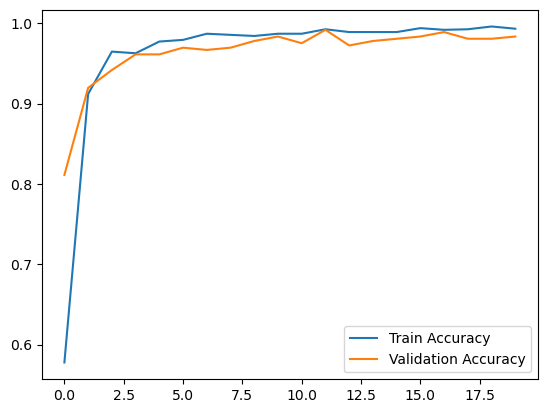

In [6]:
# Step 5: Evaluate the Model
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


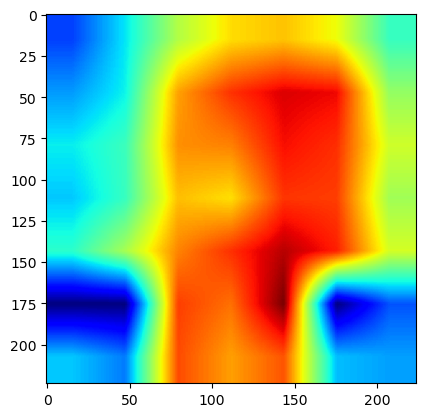

In [7]:
# Step 6: Visualizing Feature Importance with Grad-CAM
def get_gradcam(img_path, model, last_conv_layer_name):
    """
    Generate a Grad-CAM heatmap for a given image.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)/255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Create a model that maps input image to last conv layer output & predictions
    grad_model = tf.keras.models.Model([
        model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img_size, img_size))
    heatmap = np.uint8(255 * heatmap)
    return heatmap

# Example usage of Grad-CAM
sample_image_path = "C:/Users/Lenovo/Downloads/Material_defect_classification/dataset/NEU-DET/validation/images/patches/patches_270.jpg"
gradcam_result = get_gradcam(sample_image_path, model, "Conv_1")
plt.imshow(gradcam_result, cmap='jet')
plt.show()

In [8]:
# Save model after training
model.save('material_defect_classification_model.h5')